<a href="https://colab.research.google.com/github/txusser/Master_IA_Sanidad/blob/main/Modulo_2/2_3_3_Covid19_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import psycopg2 # PostgreSQL database adapter -> https://pypi.org/project/psycopg2/
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters() # Nos permite adaptar los formatos utilizados por pandas para definir datos del tipo fechas (y otros) a la definición 
# empleada por matplotlib
import matplotlib.pyplot as plt

# Conectamos con covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)

# Solicitamos la información que nos interesa aplicando una consulta (query) de SQL
cur = conn.cursor()
cur.execute("""SELECT i.* FROM
                (SELECT max(date) AS date, countrycode, adm_area_1
                FROM epidemiology WHERE source=%(source)s
                GROUP BY countrycode, adm_area_1 ) AS recent_data
              INNER JOIN epidemiology AS i
              ON i.date=recent_data.date 
              AND i.countrycode = recent_data.countrycode
              AND i.adm_area_1 = recent_data.adm_area_1
              AND i.adm_area_1 <> ''
              AND (i.adm_area_2 IS NULL OR i.adm_area_2 = '')
              AND i.source=%(source)s
              ORDER by i.confirmed DESC
            """, {'source': 'ESP_MS'})
# Ver este enlace para acceder a las fuentes de los datos -> https://github.com/covid19db/data

covid19_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [17]:
print("Primeras filas de la tabla:\n", covid19_data.head())
print("Resumen de estadísiticas:\n", covid19_data.describe())

Primeras filas de la tabla:
    source        date country  ... hospitalised_icu quarantined         gid
0  ESP_MS  2021-08-26   Spain  ...             None        None   [ESP.6_1]
1  ESP_MS  2021-08-26   Spain  ...             None        None   [ESP.8_1]
2  ESP_MS  2021-08-27   Spain  ...             None        None   [ESP.1_1]
3  ESP_MS  2021-08-26   Spain  ...             None        None  [ESP.10_1]
4  ESP_MS  2021-08-26   Spain  ...             None        None   [ESP.5_1]

[5 rows x 15 columns]
Resumen de estadísiticas:
            confirmed          dead
count      19.000000     19.000000
mean   253918.157895   4415.789474
std    288820.816005   4875.519341
min      7159.000000    101.000000
25%     75546.500000    919.000000
50%    136680.000000   2050.000000
75%    272795.000000   6672.500000
max    887826.000000  15780.000000


In [23]:
!pip install geopandas # GeoPandas no está instalada por defecto, así que tendremos

In [30]:
import geopandas
spain_geo = geopandas.read_file("http://biogeo.ucdavis.edu/data/diva/adm/ESP_adm.zip", layer='ESP_adm1')
print("Datos geográficos de España:\n")
spain_geo

Datos geográficos de España:



,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,215,ESP,Spain,1,Andalucía,Comunidad Autónoma,Autonomous Community,None,Andalousie|Andaluc¡a|Andalusien|Andaluzia,"MULTIPOLYGON (((-3.03014 35.94264, -3.03014 35..."
1,215,ESP,Spain,2,Aragón,Comunidad Autónoma,Autonomous Community,None,Aragão|Aragó|Aragón|Aragona|Aragonien,"POLYGON ((-0.74582 42.92190, -0.74409 42.91921..."
2,215,ESP,Spain,3,Cantabria,Comunidad Autónoma,Autonomous Community,None,Cantàbria|Cantábria|Cantabrie|Kantabrien,"MULTIPOLYGON (((-3.28365 43.20003, -3.28500 43..."
3,215,ESP,Spain,4,Castilla-La Mancha,Comunidad Autónoma,Autonomous Community,None,Castela-La Mancha|Castela-Mancha|Castella-la M...,"MULTIPOLYGON (((-3.36418 40.63507, -3.36655 40..."
4,215,ESP,Spain,5,Castilla y León,Comunidad Autónoma,Autonomous Community,None,Castile and Leon|Castela e Leão|Castella i Lle...,"MULTIPOLYGON (((-2.83047 42.79212, -2.82676 42..."
5,215,ESP,Spain,6,Cataluña,Comunidad Autónoma,Autonomous Community,None,Catalogna|Catalogne|Catalonia|Catalunha|Catalu...,"MULTIPOLYGON (((0.72958 40.78069, 0.72958 40.7..."
6,215,ESP,Spain,7,Ceuta y Melilla,Ciudades Autónomas,Autonomous City,None,None,"MULTIPOLYGON (((-4.30069 35.17319, -4.30069 35..."
7,215,ESP,Spain,8,Comunidad de Madrid,Comunidad Autónoma,Autonomous Community,None,Madrid|Communauté de Madrid| Community of Madr...,"MULTIPOLYGON (((-4.25646 40.66382, -4.25743 40..."
8,215,ESP,Spain,9,Comunidad Foral de Navarra,Comunidad Autónoma,Autonomous Community,None,Communauté forale de Navarre|Comunidade Foral ...,"POLYGON ((-1.65526 43.31251, -1.64447 43.30674..."
9,215,ESP,Spain,10,Comunidad Valenciana,Comunidad Autónoma,Autonomous Community,None,Valencia|Communauté de Valence|Comunidade Vale...,"MULTIPOLYGON (((-0.45708 38.16208, -0.45708 38..."


In [34]:
from shapely.geometry import Polygon

covid19_spain = italy.merge(
    covid19_data[['adm_area_1','tested','confirmed']], 
    how = 'left', left_on = 'NAME_1', right_on = 'adm_area_1'
)

covid19_spain.fillna({'confirmed':0}, inplace=True)
# add centroids 
covid19_spain['coords'] = covid19_spain['geometry'].apply(lambda x: x.centroid.coords[:])
covid19_spain['coords'] = [coords[0] for coords in covid19_spain['coords']]
covid19_spain.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,adm_area_1,tested,confirmed,coords
0,215,ESP,Spain,1,Andalucía,Comunidad Autónoma,Autonomous Community,None,Andalousie|Andaluc¡a|Andalusien|Andaluzia,"MULTIPOLYGON (((-3.03014 35.94264, -3.03014 35...",Andalucía,None,781373.0,"(-4.574030787339061, 37.46357201609444)"
1,215,ESP,Spain,2,Aragón,Comunidad Autónoma,Autonomous Community,None,Aragão|Aragó|Aragón|Aragona|Aragonien,"POLYGON ((-0.74582 42.92190, -0.74409 42.91921...",Aragón,None,157023.0,"(-0.6603016851199065, 41.519884406331535)"
2,215,ESP,Spain,3,Cantabria,Comunidad Autónoma,Autonomous Community,None,Cantàbria|Cantábria|Cantabrie|Kantabrien,"MULTIPOLYGON (((-3.28365 43.20003, -3.28500 43...",Cantabria,None,44168.0,"(-4.0314870529821665, 43.19696750971477)"
3,215,ESP,Spain,4,Castilla-La Mancha,Comunidad Autónoma,Autonomous Community,None,Castela-La Mancha|Castela-Mancha|Castella-la M...,"MULTIPOLYGON (((-3.36418 40.63507, -3.36655 40...",Castilla-La Mancha,None,229063.0,"(-3.004583305433625, 39.58109754854602)"
4,215,ESP,Spain,5,Castilla y León,Comunidad Autónoma,Autonomous Community,None,Castile and Leon|Castela e Leão|Castella i Lle...,"MULTIPOLYGON (((-2.83047 42.79212, -2.82676 42...",Castilla y León,None,293731.0,"(-4.781911108995314, 41.75434851657156)"


     |████████████████████████████████| 10.8 MB 9.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 13.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 91 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 76 kB/s 
     |████████████████████████████████| 219 kB 58.8 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516287 sha256=98f1d1a7fe52f298b17aca207a579031eec55239ccbe191dc7386f1a8f7f0a60
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=1b7b7b388085283a22ed2f6fc95ed9fbeb002077a25f

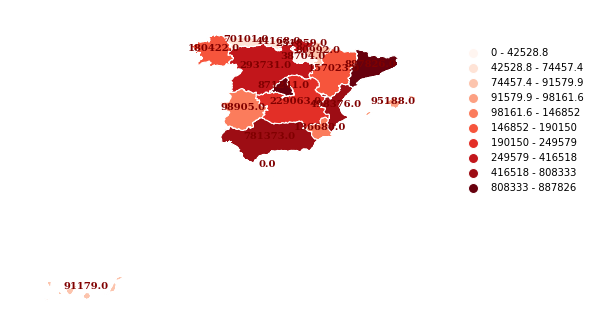

In [38]:
!pip install geoplot # Instalamos esta librería para 

<Figure size 4000x4000 with 0 Axes>

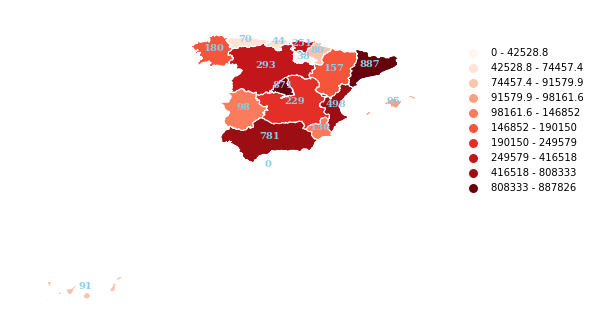

In [55]:
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

schema = mc.Quantiles(covid19_spain['confirmed'], k=10)
gplt.choropleth(
    covid19_spain,     
    hue='confirmed',     
    edgecolor='white', 
    linewidth=1,
    cmap='Reds',
    scheme=schema,
    legend=True, 
    legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
)

for _, row in covid19_spain.iterrows():
  hue = row['confirmed']
  plt.text(s=int(row['confirmed']/1000.), x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', 
           fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'skyblue',})